This script is for validating shifted altimetry data against ground truth LiDAR. It loads a ATL dataframe and underlying LiDAR file and compares the Z values along the ATL track, producing a "z_compare.csv" file.

In [53]:
from cmath import isnan
from ctypes import ArgumentError
from re import I
from statistics import mean
import pandas as pd
import datetime
import os
import argparse
import io
from csv import writer as csvWriter
import math
import numpy as np
from numpy import power as nppower
import datetime
from scipy import stats
import multiprocessing
import traceback

ATL07_SPOT_SIZE = 6

def meanChiropteraForATL(chiropteraDataFrame, atlX, atlY, spotSize):
    """
    Determines the elevation to be used as the corresponding "chiroptera elevation" for the given ATLAS sensor point.
    This works by first querying the dataframe for any points falling within the spot size radius of the given X and Y, which theoretically represent the center of the area illuminated by the ATLAS sensor's laser.
    """

    relevantPoints = chiropteraDataFrame.query("sqrt(@nppower((`x` - @atlX), 2) + @nppower((`y` - @atlY), 2)) <= @spotSize")
    maxZ = relevantPoints["z"].mean()

    return maxZ

def compareToATL07(chiropteraDataFrame, atl07DataFrame):
    """
    Performs the comparison of the given set of chiroptera data to the given set of ATLAS sensor data.
    """

    cMaxX = chiropteraDataFrame["x"].max()
    cMinX = chiropteraDataFrame["x"].min()
    cMaxY = chiropteraDataFrame["y"].max()
    cMinY = chiropteraDataFrame["y"].min()
   
    atl07InBoundsDataFrame = atl07DataFrame[(atl07DataFrame['X'] >= cMinX) & 
                               (atl07DataFrame['X'] <= cMaxX) & 
                               (atl07DataFrame['Y'] >= cMinY) & 
                               (atl07DataFrame['Y'] <= cMaxY)]
    
    #print(f"atl07InBounds has length {len(atl03InBoundsDataFrame)} ")

    chiropteraElevs = []
    atl07Elevs = []

    #this can take a while... calcChiroptera performs a mean over a spot for each corresponding z value in bounds.
    #one approach is to take every Nth Z value...
    for ind, row in atl07InBoundsDataFrame.iterrows():
        x = row["X"]
        y = row["Y"]
        z = row["Z"]
        chiropteraElev = meanChiropteraForATL(chiropteraDataFrame, x, y, ATL07_SPOT_SIZE)
        print(f"chiropteraElev: {chiropteraElev}")

        if not isnan(chiropteraElev) and not isnan(z):
            chiropteraElevs.append(chiropteraElev)
            atl07Elevs.append(z)

    dfZs = pd.DataFrame(columns=["c","a"])
    dfZs["c"] = chiropteraElevs
    dfZs["a"] = atl07Elevs
    return dfZs

In [54]:
#load 1B section as Chiroptera LiDAR DF
#load ATL from good_df 

adf = pd.read_csv('0_4_df_auto_shift.csv')
adf = adf.rename(columns={'x': 'X'})
adf = adf.rename(columns={'y': 'Y'})
adf = adf.rename(columns={'heights': 'Z'})
adf

,X,Y,slope,Z,dt,seg_dist_x,seg_dist,prev_seg_dist,next_seg_dist,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss,ocean,lpe,ib
0,570779.137260,9.497208e+06,3.118059,0.588644,1.440886e+08,1.049284e+07,5.536112,3.419722,2.768056,0.009623,1,0,0.369,6.500000,2,17.535734,-0.012468,0.057430,-0.062481
1,570777.038038,9.497201e+06,3.116949,0.528564,1.440886e+08,1.049284e+07,6.874270,2.768056,3.437135,0.007803,1,0,0.548,6.190476,2,17.535732,-0.012469,0.057430,-0.062480
2,570774.759851,9.497194e+06,3.115542,0.161404,1.440886e+08,1.049285e+07,7.457607,3.437135,3.728803,0.011042,1,0,0.278,5.727272,2,17.535671,-0.012470,0.057430,-0.062480
3,570772.220986,9.497186e+06,3.117567,0.106735,1.440886e+08,1.049286e+07,8.315591,3.728803,4.157796,0.011286,1,0,0.255,5.040000,2,17.535614,-0.012471,0.057430,-0.062480
4,570769.648837,9.497178e+06,3.118766,0.117939,1.440886e+08,1.049287e+07,8.427727,4.157796,4.213863,0.014149,1,0,0.225,5.625000,2,17.535532,-0.012473,0.057430,-0.062479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,569703.175633,9.493860e+06,3.095862,-0.204292,1.440886e+08,1.049636e+07,5.085000,2.562800,2.542500,0.057813,1,0,0.071,9.533334,0,17.513653,-0.012877,0.057423,-0.062342
560,569701.908663,9.493856e+06,3.100614,-0.215887,1.440886e+08,1.049636e+07,4.129055,2.542500,2.064527,0.045351,1,0,0.071,10.000000,0,17.513653,-0.012877,0.057423,-0.062342
561,569700.671338,9.493852e+06,3.097689,-0.207272,1.440886e+08,1.049636e+07,4.028999,2.064527,2.014500,0.042787,1,0,0.078,11.615385,0,17.513653,-0.012877,0.057423,-0.062342
562,569699.516337,9.493849e+06,3.086472,-0.203310,1.440886e+08,1.049637e+07,3.748961,2.014500,1.874481,0.048041,1,0,0.062,11.916667,0,17.513592,-0.012877,0.057423,-0.062342


In [55]:
#df should be chirop_names = ["t", "x", "y", "z"]
#df.to_pickle('chiroptera_1b.pkl')
df = pd.read_csv('chirop_0_4.csv')

In [56]:
dfZs = compareToATL07(df, adf)

chiropteraElev: 0.686256814470301
chiropteraElev: 0.7269578388112476
chiropteraElev: 0.6893916109491166
chiropteraElev: 0.32442971545433
chiropteraElev: 0.3823728220070941
chiropteraElev: 0.3477393542589757
chiropteraElev: 0.35070836736876465
chiropteraElev: 0.38536428388964417
chiropteraElev: 0.23979093731286263
chiropteraElev: nan
chiropteraElev: nan
chiropteraElev: 0.0974689085546437
chiropteraElev: 0.11447248288808327
chiropteraElev: 0.08593566501945597
chiropteraElev: 0.013431634413883882
chiropteraElev: -0.05593552143681384
chiropteraElev: 0.05986939941154146
chiropteraElev: 0.0700541311157391
chiropteraElev: 0.06421154016152142
chiropteraElev: 0.003045009781067461
chiropteraElev: -0.033829625173293354
chiropteraElev: -0.02356861217863758
chiropteraElev: -0.025815248933871954
chiropteraElev: -0.014373253227236036
chiropteraElev: nan
chiropteraElev: nan
chiropteraElev: -0.009279110555835052
chiropteraElev: 0.13772194663094572
chiropteraElev: 0.14012408008007382
chiropteraElev: 0.0

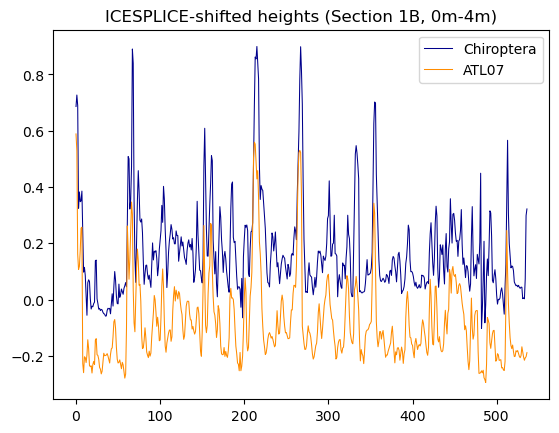

0.6450739458143645


In [58]:
#Visualize Z-Compare
import pandas as pd
import matplotlib.pyplot as plt

# # Load the CSV file
# file_path = 'z_compare.csv'
# data = pd.read_csv(file_path)

x = dfZs.index
#chirop
y1 = dfZs['c']

#atl
y2 = dfZs['a']

fig,ax = plt.subplots()
# Plot the data
plt.plot(x, y1, label='Chiroptera', color='darkblue',linewidth=0.75)
plt.plot(x, y2, label='ATL07', color='darkorange',linewidth=0.75)
plt.legend()

slope, intercept, r_value, p_value, std_err = stats.linregress(y1, y2)

plt.title('ICESPLICE-shifted heights (Section 1B, 0m-4m)')
#plt.grid(True)
plt.show()
print(r_value**2)